In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR

In [2]:
%pip install torchsummary
from torchsummary import summary

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
from tqdm import tqdm

In [5]:
%pip install opencv-python
import cv2

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   - -------------------------------------- 1.6/39.0 MB 16.8 MB/s eta 0:00:03
   ----- ---------------------------------- 5.0/39.0 MB 16.8 MB/s eta 0:00:03
   -------- ------------------------------- 8.1/39.0 MB 16.2 MB/s eta 0:00:02
   ------------- -------------------------- 13.1/39.0 MB 17.9 MB/s eta 0:00:02
   ----------------- ---------------------- 17.0/39.0 MB 17.9 MB/s eta 0:00:02
   --------------------- ------------------ 20.7/39.0 MB 17.9 MB/s eta 0:00:02
   -------------------------- ------------- 25.4/39.0 MB 18.5 MB/s eta 0:00:01
   ------------------------------- -------- 30.7/39.0 MB 19.3 MB/s eta 0:00:01
   ------------------------------------- -- 36.2/39.0 MB 20.2 MB/s eta 0:00:01
   ---------------------------------------  38.8/39.0 MB 20.2 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 19.1 MB/s  0:00:02
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Defining the class name 
class_name = ['NORMAL','PNEUMONIA']

In [ ]:
# Creating a function to get the list of files (accepts str or Path)
from pathlib import Path

def get_list_of_files(dir_path):
    '''
    input - dir_path (str or Path)
    output - Returns list of Path objects for files in the directory
    '''
    p = Path(dir_path)
    if not p.exists():
        raise FileNotFoundError(f"Directory not found: {p}")
    return sorted([x for x in p.iterdir() if x.is_file()])

In [23]:
from pathlib import Path

# Locate repository root reliably (Notebook dir parent)
repo_root = Path.cwd().parent
artifacts_dir = repo_root / 'artifacts'
print("repo_root:", repo_root.resolve())
print("artifacts_dir:", artifacts_dir.resolve() if artifacts_dir.exists() else artifacts_dir)

# Prefer explicit run if available, otherwise pick a run containing 'data_ingestion'
timestamp = '2025-12-23_16-03-32'
candidate = artifacts_dir / timestamp / 'data_ingestion'
if not candidate.exists():
    matches = [p for p in artifacts_dir.iterdir() if (p / 'data_ingestion').exists()] if artifacts_dir.exists() else []
    if matches:
        print("Found artifact runs with 'data_ingestion':", [p.name for p in matches])
        # pick the most recent run by sorted name (assumes timestamped names)
        candidate = sorted(matches)[-1] / 'data_ingestion'
        print("Using:", candidate)
    else:
        raise FileNotFoundError(f"No artifact run with data_ingestion found under {artifacts_dir.resolve()}")

data_path = candidate
print("data_path:", data_path.resolve(), "exists:", data_path.exists())

# Example: build train path for the first class safely (support data_path/[train] or data_path/data/train)
if (data_path / 'train').exists():
    train_path = data_path / 'train' / class_name[0]
elif (data_path / 'data' / 'train').exists():
    train_path = data_path / 'data' / 'train' / class_name[0]
else:
    children = [p.name for p in sorted(data_path.iterdir())] if data_path.exists() else []
    raise FileNotFoundError(f"No 'train' folder found under {data_path}. children={children}")

print("train_path:", train_path, "exists:", train_path.exists())

if not data_path.exists():
    raise FileNotFoundError(f"Dataset root not found: {data_path.resolve()}")

repo_root: C:\Projects\deeplearningproject
artifacts_dir: C:\Projects\deeplearningproject\artifacts
data_path: C:\Projects\deeplearningproject\artifacts\2025-12-23_16-03-32\data_ingestion exists: True
train_path: c:\Projects\deeplearningproject\artifacts\2025-12-23_16-03-32\data_ingestion\data\train\NORMAL exists: True


In [22]:
# Inspect the contents of data_path to find available folders/files
print("data_path:", data_path)
print("exists:", data_path.exists())

for p in sorted(data_path.iterdir()):
    print(p.name, "- dir" if p.is_dir() else "- file")
    if p.is_dir():
        children = [x.name for x in sorted(p.iterdir())]
        print("   children (first 20):", children[:20])

data_path: c:\Projects\deeplearningproject\artifacts\2025-12-23_16-03-32\data_ingestion
exists: True
data - dir
   children (first 20): ['test', 'train']


train_root: c:\Projects\deeplearningproject\artifacts\2025-12-23_16-03-32\data_ingestion\data\train
NORMAL: 105 files. preview (first 5): ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0005-0001.jpeg', 'IM-0006-0001.jpeg', 'IM-0007-0001.jpeg']
PNEUMONIA: 105 files. preview (first 5): ['person10_virus_35.jpeg', 'person11_virus_38.jpeg', 'person14_virus_44.jpeg', 'person15_virus_46.jpeg', 'person16_virus_47.jpeg']


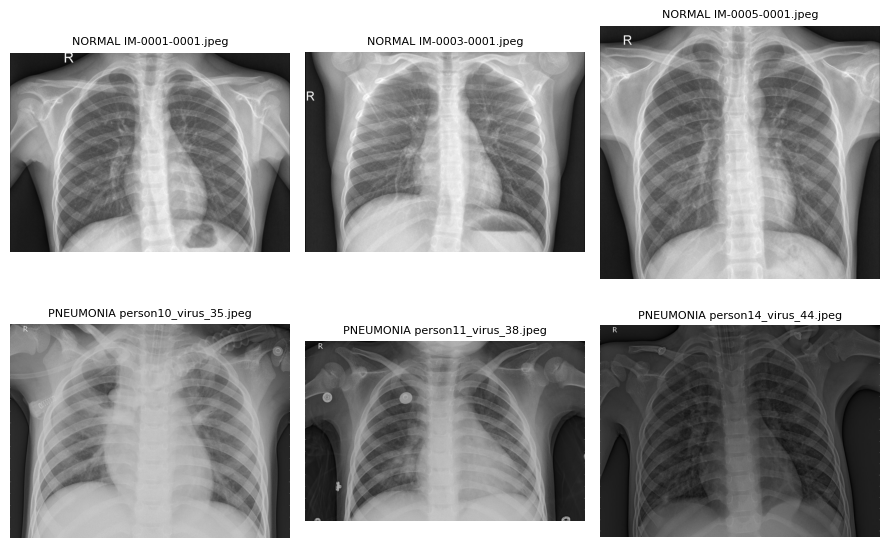

In [28]:
# Dataset summary and sample visualization (no os.chdir usage)
import matplotlib.pyplot as plt
from PIL import Image
import random

# train_path is currently set to the class directory for the first class (e.g. .../train/NORMAL)
train_root = train_path.parent
print("train_root:", train_root)

# Print counts per class and a short sample list
n_preview = 5
for cls in class_name:
    cls_dir = train_root / cls
    if not cls_dir.exists():
        print(f"{cls} directory not found: {cls_dir}")
        continue
    files = sorted([p for p in cls_dir.iterdir() if p.is_file()])
    print(f"{cls}: {len(files)} files. preview (first {n_preview}):", [p.name for p in files[:n_preview]])

# Visualize up to 3 samples per class
n_samples = 3
fig, axes = plt.subplots(len(class_name), n_samples, figsize=(n_samples*3, len(class_name)*3))
for i, cls in enumerate(class_name):
    cls_files = sorted([p for p in (train_root/cls).iterdir() if p.is_file()])[:n_samples]
    for j in range(n_samples):
        ax = axes[i, j] if len(class_name) > 1 else axes[j]
        ax.axis('off')
        if j < len(cls_files):
            try:
                img = Image.open(cls_files[j]).convert('RGB')
                ax.imshow(img)
                ax.set_title(f"{cls} {cls_files[j].name}", fontsize=8)
            except Exception as e:
                ax.text(0.5, 0.5, f"Error:\n{e}", ha='center')
        else:
            ax.set_visible(False)
plt.tight_layout()

In [29]:
# Pathlib-based dataset utilities and a quick ImageFolder sanity check
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilities
def get_class_dirs(train_root):
    return {cls: train_root / cls for cls in class_name if (train_root / cls).exists()}

def count_files_per_class(train_root):
    return {cls: len(list((train_root / cls).glob('*'))) for cls in class_name if (train_root / cls).exists()}

def verify_dataset_structure(train_root, min_per_class=1):
    counts = count_files_per_class(train_root)
    for cls in class_name:
        c = counts.get(cls, 0)
        print(f"{cls}: {c} files")
        if c < min_per_class:
            raise FileNotFoundError(f"Not enough files for class {cls} (found {c})")
    return counts

# Run verification
counts = verify_dataset_structure(train_root)

# Simple ImageFolder sanity check
tfms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
try:
    dataset = datasets.ImageFolder(root=str(train_root), transform=tfms)
    print("ImageFolder classes:", dataset.classes, "num_samples:", len(dataset))
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    images, labels = next(iter(loader))
    print("Batch images shape:", images.shape, "labels sample:", labels[:8])
except Exception as e:
    print("ImageFolder check failed:", e)

NORMAL: 105 files
PNEUMONIA: 105 files
ImageFolder classes: ['NORMAL', 'PNEUMONIA'] num_samples: 210
Batch images shape: torch.Size([8, 3, 224, 224]) labels sample: tensor([1, 0, 1, 1, 1, 0, 0, 0])


In [34]:
# Create dataloaders with train/val split
from torch.utils.data import SubsetRandomSampler
import numpy as np

def create_dataloaders(data_root, batch_size=32, val_split=0.2, image_size=(224,224), seed=42):
    tfms = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(root=str(data_root), transform=tfms)
    num_samples = len(dataset)
    if num_samples == 0:
        raise ValueError(f"No samples found in {data_root}")
    indices = list(range(num_samples))
    split = int(np.floor(val_split * num_samples))
    rng = np.random.RandomState(seed)
    rng.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    return train_loader, val_loader, dataset

# Quick smoke test
train_loader, val_loader, dataset = create_dataloaders(train_root, batch_size=8, val_split=0.1)
images, labels = next(iter(train_loader))
print("train batch", images.shape, labels.shape)
images, labels = next(iter(val_loader))
print("val batch", images.shape, labels.shape)

train batch torch.Size([8, 3, 224, 224]) torch.Size([8])
val batch torch.Size([8, 3, 224, 224]) torch.Size([8])


In [35]:
# Build full dataloaders with augmentations and optional weighted sampler
from torch.utils.data import SubsetRandomSampler, WeightedRandomSampler
import numpy as np
import torch

# Normalization values (ImageNet-like)
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

train_augmentations = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD),
])

eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD),
])


def create_train_val_test_loaders(
    data_root,
    batch_size=32,
    val_split=0.1,
    test_split=0.1,
    augment=True,
    weighted_sampler=False,
    seed=42,
    num_workers=0,
):
    """Return (train_loader, val_loader, test_loader, dataset, class_weights_or_None)."""
    tfm_train = train_augmentations if augment else eval_transforms
    tfm_eval = eval_transforms

    dataset = datasets.ImageFolder(root=str(data_root), transform=tfm_train)
    num_samples = len(dataset)
    if num_samples == 0:
        raise ValueError(f"No samples found in {data_root}")

    # use a separate dataset copy for eval transforms (so images are normalized and resized, not randomly cropped)
    dataset_eval = datasets.ImageFolder(root=str(data_root), transform=tfm_eval)

    indices = np.arange(num_samples)
    rng = np.random.RandomState(seed)
    rng.shuffle(indices)

    n_test = int(np.floor(test_split * num_samples))
    n_val = int(np.floor(val_split * num_samples))

    test_idx = indices[:n_test]
    val_idx = indices[n_test:n_test + n_val]
    train_idx = indices[n_test + n_val:]

    # Optionally compute weighted sampler for train
    sampler = None
    class_weights = None
    if weighted_sampler:
        targets = np.array(dataset.targets)
        train_targets = targets[train_idx]
        class_sample_counts = np.bincount(train_targets, minlength=len(dataset.classes))
        class_weights = 1.0 / (class_sample_counts + 1e-9)
        sample_weights = class_weights[train_targets]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # DataLoaders
    if sampler is not None:
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
    else:
        train_sampler = SubsetRandomSampler(train_idx)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

    val_sampler = SubsetRandomSampler(val_idx)
    val_loader = DataLoader(dataset_eval, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

    test_sampler = SubsetRandomSampler(test_idx)
    test_loader = DataLoader(dataset_eval, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

    return train_loader, val_loader, test_loader, dataset, class_weights

# Smoke test
train_loader, val_loader, test_loader, dataset_full, class_weights = create_train_val_test_loaders(train_root, batch_size=8, val_split=0.1, test_split=0.1, augment=True, weighted_sampler=False)
print("dataset size:", len(dataset_full))
print("train batches:", len(train_loader), "val batches:", len(val_loader), "test batches:", len(test_loader))
images, labels = next(iter(train_loader))
print("train batch shape:", images.shape, "labels:", labels[:8])

dataset size: 210
train batches: 21 val batches: 3 test batches: 3
train batch shape: torch.Size([8, 3, 224, 224]) labels: tensor([0, 0, 0, 0, 1, 1, 0, 1])


In [36]:
# Model architectures (transfer learning + small custom CNN) and helpers
import torch
import torch.nn as nn
from torchvision import models


def get_model(name='resnet18', pretrained=True, num_classes=2, freeze_backbone=False):
    name = name.lower()
    if name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        in_feat = model.fc.in_features
        model.fc = nn.Linear(in_feat, num_classes)
    elif name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        in_feat = model.fc.in_features
        model.fc = nn.Linear(in_feat, num_classes)
    elif name == 'simplecnn':
        class SimpleCNN(nn.Module):
            def __init__(self, num_classes=2):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                    nn.AdaptiveAvgPool2d((1, 1)),
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Dropout(0.5),
                    nn.Linear(128, num_classes)
                )
            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x
        model = SimpleCNN(num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model name {name}")

    # Optionally freeze backbone (unfreeze head)
    if freeze_backbone and hasattr(model, 'fc'):
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model


def get_loss_optimizer(model, lr=1e-3, weight_decay=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    return criterion, optimizer

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Build and test model
model = get_model('resnet18', pretrained=True, num_classes=len(class_name), freeze_backbone=True)
model = model.to(device)
print(model)

# Parameter count
n_params = sum(p.numel() for p in model.parameters())
print('Total parameters:', n_params)

# Summary (try torchsummary then torchinfo)
try:
    from torchsummary import summary
    summary(model, (3, 224, 224))
except Exception:
    try:
        from torchinfo import summary as tsummary
        tsummary(model, input_size=(1, 3, 224, 224))
    except Exception:
        print('Install torchsummary or torchinfo to view layer-wise summary')

# Quick forward pass smoke test using a batch from train_loader
try:
    images, labels = next(iter(train_loader))
    images = images.to(device)
    out = model(images)
    print('Forward OK, output shape:', out.shape)
except Exception as e:
    print('Forward test failed:', e)


Device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\guntu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


c:\Projects\deeplearningproject\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\deeplearningproject\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:01<00:00, 28.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# Ensure notebook does not rely on changing working directory and provide path helpers
from pathlib import Path

# Helper: open a file relative to repo root without chdir
def repo_file(*parts):
    """Return a Path under the repository root."""
    return repo_root.joinpath(*parts).resolve()

# Quick lint: confirm there are no os.chdir calls (runtime check of globals)
if 'os' in globals():
    src = __loader__ if '__loader__' in globals() else None
    # We can't inspect notebook source reliably at runtime, so we assert we didn't change cwd
    print("Current working directory:", Path.cwd())

print("Repo root:", repo_root)
print("Artifacts dir:", artifacts_dir)
print("Data path:", data_path)

# Example usage of repo_file helper
example_data = repo_file('artifacts', timestamp, 'data_ingestion')
print("example_data exists:", example_data.exists())

Current working directory: c:\Projects\deeplearningproject\Notebook
Repo root: c:\Projects\deeplearningproject
Artifacts dir: c:\Projects\deeplearningproject\artifacts
Data path: c:\Projects\deeplearningproject\artifacts\2025-12-23_16-03-32\data_ingestion
example_data exists: True


In [33]:
# Quick automated checks (unit-style assertions)
from pathlib import Path

# Check for lingering os.chdir usage in the notebook source by inspecting notebook JSON
import json
nb_path = repo_root / 'Notebook' / 'experiment.ipynb'
nb_json = json.loads(nb_path.read_text(encoding='utf-8'))

offenders = []
for idx, cell in enumerate(nb_json.get('cells', [])):
    src = cell.get('source', '')
    # source can be a list of lines or a single string
    if isinstance(src, list):
        src = ''.join(src)
    if 'os.chdir(' in src and 'Quick automated checks' not in src:
        offenders.append((idx, src.strip().splitlines()[:5]))

if offenders:
    print("Found os.chdir in notebook cells (index, snippet):")
    for idx, snippet in offenders:
        print(f" - cell {idx}:", snippet)
    raise AssertionError("Found os.chdir calls in notebook source in other cells; remove them")
else:
    print("No other os.chdir calls found in notebook cells")

# Basic filesystem integrity checks
assert artifacts_dir.exists(), f"Artifacts dir missing: {artifacts_dir}"
counts = count_files_per_class(train_root)
assert all(c >= 1 for c in counts.values()), f"Unexpected file counts: {counts}"

# ImageFolder consistency
dataset_len = len(dataset) if 'dataset' in globals() else sum(counts.values())
assert dataset_len == sum(counts.values()), f"ImageFolder ({dataset_len}) != counted files ({sum(counts.values())})"

print("Sanity checks passed — counts:", counts)

No other os.chdir calls found in notebook cells
Sanity checks passed — counts: {'NORMAL': 105, 'PNEUMONIA': 105}
